# More Preprocess

In [ ]:
# Core
import numpy as np
import pandas as pd

# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
    
)

from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# SHAP
import shap

# Misc
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42


In [4]:
#Check Original Data

data_path = "diabetes_012_health_indicators_BRFSS2015.csv"
df = pd.read_csv(data_path)

print(df.shape)
df.head()


(253680, 22)


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [5]:
#check how many value for each target class
df['Diabetes_012'].value_counts()

Diabetes_012
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64

In [6]:
import pandas as pd

# Load data
X_train = pd.read_csv("x_train.csv", index_col=0)
X_test  = pd.read_csv("x_test.csv",  index_col=0)

y_train = pd.read_csv("y_train.csv", index_col=0).squeeze("columns")
y_test  = pd.read_csv("y_test.csv",  index_col=0).squeeze("columns")

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)


X_train: (228312, 20)
X_test : (25368, 20)
y_train: (228312,)
y_test : (25368,)


In [7]:
import numpy as np
np.unique(y_train), np.unique(y_test)


(array([0., 1., 2.]), array([0., 1., 2.]))

In [8]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
import numpy as np

def evaluate_on_test_set(model, X_test, y_test):
    
    # Predictions
    y_pred = model.predict(X_test)

    # ROC-AUC (multiclass OvR)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        auc = roc_auc_score(y_test, y_proba, multi_class="ovr")
    else:
        auc = np.nan

    # Macro-averaged multiclass metrics
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)
    f1   = f1_score(y_test, y_pred, average="macro", zero_division=0)

    # print the results
    print("=== Test set performance ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision (macro): {prec:.4f}")
    print(f"Recall (macro)   : {rec:.4f}")
    print(f"F1-score (macro) : {f1:.4f}")
    print(f"AUC-ROC (OvR)    : {auc:.4f}")
    print()

    print("Classification report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))

    return {
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1,
        "auc_roc_ovr": auc
    }


# KNN

In [13]:
knn_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

knn_param_grid = {
    "knn__n_neighbors": [3,10,25,50, 100, 500],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2]   # 1 = Manhattan, 2 = Euclidean
}


knn_scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, average="macro"),
    "recall": make_scorer(recall_score, average="macro"),
    "f1": make_scorer(f1_score, average="macro"),
    "roc_auc": "roc_auc_ovr"
}
knn_grid = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=knn_param_grid,
    scoring=knn_scoring,
    refit="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=2
)

knn_grid.fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time= 2.4min
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time= 2.4min
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time= 2.4min
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time= 2.4min
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time= 2.4min
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time= 2.4min
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time= 2.5min
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time= 2.5min
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time= 2.5min
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time= 2.5min
[CV] END .knn__n_neighbors=3, knn__p=2, knn__weights=uniform; total time=  50.8s
[CV] END .knn__n_neighbors=3, knn__p=2, knn__we

/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END knn__n_neighbors=10, knn__p=1, knn__weights=uniform; total time= 2.5min
[CV] END knn__n_neighbors=10, knn__p=1, knn__weights=uniform; total time= 2.5min
[CV] END knn__n_neighbors=10, knn__p=1, knn__weights=uniform; total time= 2.5min
[CV] END knn__n_neighbors=10, knn__p=1, knn__weights=uniform; total time= 2.5min
[CV] END knn__n_neighbors=10, knn__p=1, knn__weights=distance; total time= 2.5min
[CV] END knn__n_neighbors=10, knn__p=1, knn__weights=uniform; total time= 2.5min
[CV] END knn__n_neighbors=10, knn__p=1, knn__weights=distance; total time= 2.5min
[CV] END knn__n_neighbors=10, knn__p=1, knn__weights=distance; total time= 2.5min
[CV] END knn__n_neighbors=10, knn__p=1, knn__weights=distance; total time= 2.5min
[CV] END knn__n_neighbors=10, knn__p=1, knn__weights=distance; total time= 2.5min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END knn__n_neighbors=10, knn__p=2, knn__weights=uniform; total time=  52.4s
[CV] END knn__n_neighbors=10, knn__p=2, knn__weights=uniform; total time=  53.1s
[CV] END knn__n_neighbors=10, knn__p=2, knn__weights=uniform; total time=  52.3s
[CV] END knn__n_neighbors=10, knn__p=2, knn__weights=uniform; total time=  52.3s
[CV] END knn__n_neighbors=10, knn__p=2, knn__weights=distance; total time=  52.2s
[CV] END knn__n_neighbors=10, knn__p=2, knn__weights=uniform; total time=  52.8s
[CV] END knn__n_neighbors=10, knn__p=2, knn__weights=distance; total time=  52.2s
[CV] END knn__n_neighbors=10, knn__p=2, knn__weights=distance; total time=  51.4s
[CV] END knn__n_neighbors=10, knn__p=2, knn__weights=distance; total time=  52.0s
[CV] END knn__n_neighbors=10, knn__p=2, knn__weights=distance; total time=  52.2s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

[CV] END knn__n_neighbors=25, knn__p=1, knn__weights=uniform; total time= 2.5min
[CV] END knn__n_neighbors=25, knn__p=1, knn__weights=uniform; total time= 2.5min
[CV] END knn__n_neighbors=25, knn__p=1, knn__weights=uniform; total time= 2.5min
[CV] END knn__n_neighbors=25, knn__p=1, knn__weights=uniform; total time= 2.5min
[CV] END knn__n_neighbors=25, knn__p=1, knn__weights=uniform; total time= 2.5min
[CV] END knn__n_neighbors=25, knn__p=1, knn__weights=distance; total time= 2.5min
[CV] END knn__n_neighbors=25, knn__p=1, knn__weights=distance; total time= 2.5min
[CV] END knn__n_neighbors=25, knn__p=1, knn__weights=distance; total time= 2.5min
[CV] END knn__n_neighbors=25, knn__p=1, knn__weights=distance; total time= 2.6min
[CV] END knn__n_neighbors=25, knn__p=1, knn__weights=distance; total time= 2.5min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

[CV] END knn__n_neighbors=25, knn__p=2, knn__weights=uniform; total time=  53.4s
[CV] END knn__n_neighbors=25, knn__p=2, knn__weights=uniform; total time=  53.6s
[CV] END knn__n_neighbors=25, knn__p=2, knn__weights=uniform; total time=  53.8s
[CV] END knn__n_neighbors=25, knn__p=2, knn__weights=distance; total time=  53.1s
[CV] END knn__n_neighbors=25, knn__p=2, knn__weights=distance; total time=  52.5s
[CV] END knn__n_neighbors=25, knn__p=2, knn__weights=uniform; total time=  53.7s
[CV] END knn__n_neighbors=25, knn__p=2, knn__weights=uniform; total time=  53.9s
[CV] END knn__n_neighbors=25, knn__p=2, knn__weights=distance; total time=  53.1s
[CV] END knn__n_neighbors=25, knn__p=2, knn__weights=distance; total time=  52.7s
[CV] END knn__n_neighbors=25, knn__p=2, knn__weights=distance; total time=  52.9s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

[CV] END knn__n_neighbors=50, knn__p=1, knn__weights=uniform; total time= 2.6min
[CV] END knn__n_neighbors=50, knn__p=1, knn__weights=uniform; total time= 2.6min
[CV] END knn__n_neighbors=50, knn__p=1, knn__weights=uniform; total time= 2.6min
[CV] END knn__n_neighbors=50, knn__p=1, knn__weights=uniform; total time= 2.6min
[CV] END knn__n_neighbors=50, knn__p=1, knn__weights=distance; total time= 2.6min
[CV] END knn__n_neighbors=50, knn__p=1, knn__weights=distance; total time= 2.6min
[CV] END knn__n_neighbors=50, knn__p=1, knn__weights=uniform; total time= 2.6min
[CV] END knn__n_neighbors=50, knn__p=1, knn__weights=distance; total time= 2.6min
[CV] END knn__n_neighbors=50, knn__p=1, knn__weights=distance; total time= 2.6min
[CV] END knn__n_neighbors=50, knn__p=1, knn__weights=distance; total time= 2.6min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

[CV] END knn__n_neighbors=50, knn__p=2, knn__weights=uniform; total time=  54.9s
[CV] END knn__n_neighbors=50, knn__p=2, knn__weights=uniform; total time=  55.2s
[CV] END knn__n_neighbors=50, knn__p=2, knn__weights=uniform; total time=  55.2s
[CV] END knn__n_neighbors=50, knn__p=2, knn__weights=uniform; total time=  54.7s
[CV] END knn__n_neighbors=50, knn__p=2, knn__weights=distance; total time=  54.3s
[CV] END knn__n_neighbors=50, knn__p=2, knn__weights=uniform; total time=  55.2s
[CV] END knn__n_neighbors=50, knn__p=2, knn__weights=distance; total time=  54.1s
[CV] END knn__n_neighbors=50, knn__p=2, knn__weights=distance; total time=  54.6s
[CV] END knn__n_neighbors=50, knn__p=2, knn__weights=distance; total time=  54.7s
[CV] END knn__n_neighbors=50, knn__p=2, knn__weights=distance; total time=  54.7s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

[CV] END knn__n_neighbors=100, knn__p=1, knn__weights=uniform; total time= 2.6min
[CV] END knn__n_neighbors=100, knn__p=1, knn__weights=distance; total time= 2.6min
[CV] END knn__n_neighbors=100, knn__p=1, knn__weights=uniform; total time= 2.7min
[CV] END knn__n_neighbors=100, knn__p=1, knn__weights=uniform; total time= 2.7min
[CV] END knn__n_neighbors=100, knn__p=1, knn__weights=uniform; total time= 2.7min
[CV] END knn__n_neighbors=100, knn__p=1, knn__weights=distance; total time= 2.7min
[CV] END knn__n_neighbors=100, knn__p=1, knn__weights=uniform; total time= 2.7min
[CV] END knn__n_neighbors=100, knn__p=1, knn__weights=distance; total time= 2.7min
[CV] END knn__n_neighbors=100, knn__p=1, knn__weights=distance; total time= 2.7min
[CV] END knn__n_neighbors=100, knn__p=1, knn__weights=distance; total time= 2.7min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

[CV] END knn__n_neighbors=100, knn__p=2, knn__weights=uniform; total time=  57.9s
[CV] END knn__n_neighbors=100, knn__p=2, knn__weights=uniform; total time=  57.7s
[CV] END knn__n_neighbors=100, knn__p=2, knn__weights=uniform; total time=  57.9s
[CV] END knn__n_neighbors=100, knn__p=2, knn__weights=uniform; total time=  57.9s
[CV] END knn__n_neighbors=100, knn__p=2, knn__weights=distance; total time=  57.2s
[CV] END knn__n_neighbors=100, knn__p=2, knn__weights=distance; total time=  57.3s
[CV] END knn__n_neighbors=100, knn__p=2, knn__weights=uniform; total time=  58.1s
[CV] END knn__n_neighbors=100, knn__p=2, knn__weights=distance; total time=  57.9s
[CV] END knn__n_neighbors=100, knn__p=2, knn__weights=distance; total time=  57.2s
[CV] END knn__n_neighbors=100, knn__p=2, knn__weights=distance; total time=  57.8s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

[CV] END knn__n_neighbors=500, knn__p=1, knn__weights=uniform; total time= 3.2min
[CV] END knn__n_neighbors=500, knn__p=1, knn__weights=uniform; total time= 3.2min
[CV] END knn__n_neighbors=500, knn__p=1, knn__weights=distance; total time= 3.1min
[CV] END knn__n_neighbors=500, knn__p=1, knn__weights=uniform; total time= 3.2min
[CV] END knn__n_neighbors=500, knn__p=1, knn__weights=uniform; total time= 3.2min
[CV] END knn__n_neighbors=500, knn__p=1, knn__weights=distance; total time= 3.2min
[CV] END knn__n_neighbors=500, knn__p=1, knn__weights=distance; total time= 3.2min
[CV] END knn__n_neighbors=500, knn__p=1, knn__weights=distance; total time= 3.2min
[CV] END knn__n_neighbors=500, knn__p=1, knn__weights=distance; total time= 3.2min
[CV] END knn__n_neighbors=500, knn__p=1, knn__weights=uniform; total time= 3.3min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

[CV] END knn__n_neighbors=500, knn__p=2, knn__weights=uniform; total time= 1.3min
[CV] END knn__n_neighbors=500, knn__p=2, knn__weights=uniform; total time= 1.3min
[CV] END knn__n_neighbors=500, knn__p=2, knn__weights=uniform; total time= 1.3min
[CV] END knn__n_neighbors=500, knn__p=2, knn__weights=uniform; total time= 1.3min
[CV] END knn__n_neighbors=500, knn__p=2, knn__weights=uniform; total time= 1.3min
[CV] END knn__n_neighbors=500, knn__p=2, knn__weights=distance; total time= 1.3min
[CV] END knn__n_neighbors=500, knn__p=2, knn__weights=distance; total time= 1.3min
[CV] END knn__n_neighbors=500, knn__p=2, knn__weights=distance; total time= 1.3min
[CV] END knn__n_neighbors=500, knn__p=2, knn__weights=distance; total time= 1.3min
[CV] END knn__n_neighbors=500, knn__p=2, knn__weights=distance; total time= 1.3min


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [3, 10, 25, 50, 100, 500],
                         'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance']},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy',
                      'f1': make_scorer(f1_score, response_method='predict', average=macro),
                      'precision': make_scorer(precision_score, response_method='predict', average=macro),
                      'recall': make_scorer(recall_score, response_method='predict', average=macro),
                      'roc_auc': 'roc_auc_ovr'},
             verbose=2)

In [14]:
print("Best KNN params:", knn_grid.best_params_)
print("Best CV AUC-ROC:", knn_grid.best_score_)

knn_cv_results = pd.DataFrame(knn_grid.cv_results_)
knn_cv_results[[
    "mean_test_accuracy",
    "mean_test_precision",
    "mean_test_recall",
    "mean_test_f1",
    "mean_test_roc_auc",
    "param_knn__n_neighbors",
    "param_knn__weights",
    "param_knn__p"
]].sort_values("mean_test_roc_auc", ascending=False).head(10)


Best KNN params: {'knn__n_neighbors': 500, 'knn__p': 1, 'knn__weights': 'uniform'}
Best CV AUC-ROC: 0.7736740582579801


,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc,param_knn__n_neighbors,param_knn__weights,param_knn__p
20,0.845825,0.497169,0.349188,0.337373,0.773674,500,uniform,1
22,0.845869,0.496485,0.349485,0.337944,0.770077,500,uniform,2
21,0.843009,0.463749,0.351322,0.342625,0.758169,500,distance,1
16,0.847200,0.485560,0.359757,0.356712,0.756767,100,uniform,1
23,0.842847,0.462112,0.351336,0.342705,0.755267,500,distance,2
18,0.846609,0.480219,0.359322,0.356053,0.754128,100,uniform,2
17,0.844139,0.466386,0.362491,0.362071,0.745258,100,distance,1
19,0.843753,0.464090,0.361998,0.361305,0.743609,100,distance,2
14,0.846464,0.471904,0.364896,0.365471,0.741364,50,uniform,2
12,0.846828,0.474681,0.364726,0.365156,0.741070,50,uniform,1


In [15]:
best_knn = knn_grid.best_estimator_
knn_test_metrics = evaluate_on_test_set(best_knn, X_test, y_test)


=== Test set performance ===
Accuracy : 0.8461
Precision (macro): 0.4774
Recall (macro)   : 0.3498
F1-score (macro) : 0.3392
AUC-ROC (OvR)    : 0.7724

Classification report:
              precision    recall  f1-score   support

         0.0       0.85      0.99      0.92     21401
         1.0       0.00      0.00      0.00       473
         2.0       0.58      0.06      0.10      3494

    accuracy                           0.85     25368
   macro avg       0.48      0.35      0.34     25368
weighted avg       0.80      0.85      0.79     25368

Confusion matrix:
[[21271     0   130]
 [  464     0     9]
 [ 3300     0   194]]


Class 0 — No Diabetes
• Precision: 0.86
• Recall:    0.98
• F1-score:  0.91
• Support:   21,401

Class 1 — Prediabetes
• Precision: 0.00
• Recall:    0.00
• F1-score:  0.00
• Support:   473

Class 2 — Diabetes
• Precision: 0.49
• Recall:    0.15
• F1-score:  0.23
• Support:   3,494


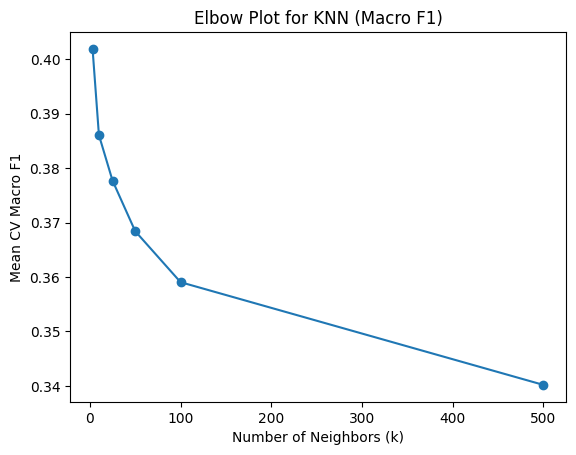

In [16]:
elbow_f1_df = (
    knn_cv_results
    .groupby("param_knn__n_neighbors")["mean_test_f1"]
    .mean()
    .reset_index()
)

plt.figure()
plt.plot(
    elbow_f1_df["param_knn__n_neighbors"],
    elbow_f1_df["mean_test_f1"],
    marker="o"
)
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean CV Macro F1")
plt.title("Elbow Plot for KNN (Macro F1)")
plt.show()


# Random Forest

In [17]:
rf_pipeline = Pipeline(steps=[
    ("rf", RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

rf_param_grid = {
    "rf__n_estimators": [100],
    "rf__max_depth": [None, 100, 200],
    "rf__min_samples_split": [20, 100, 200],
    "rf__min_samples_leaf": [10, 40, 90]
}


rf_scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, average="macro"),
    "recall": make_scorer(recall_score, average="macro"),
    "f1": make_scorer(f1_score, average="macro"),
    "roc_auc": "roc_auc_ovr"
}

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    scoring=rf_scoring,
    refit="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=2
)


rf_grid.fit(X_train, y_train)



Fitting 5 folds for each of 27 candidates, totalling 135 fits


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

[CV] END rf__max_depth=None, rf__min_samples_leaf=10, rf__min_samples_split=100, rf__n_estimators=100; total time=  14.6s
[CV] END rf__max_depth=None, rf__min_samples_leaf=10, rf__min_samples_split=100, rf__n_estimators=100; total time=  14.6s
[CV] END rf__max_depth=None, rf__min_samples_leaf=10, rf__min_samples_split=100, rf__n_estimators=100; total time=  14.7s
[CV] END rf__max_depth=None, rf__min_samples_leaf=10, rf__min_samples_split=100, rf__n_estimators=100; total time=  15.0s
[CV] END rf__max_depth=None, rf__min_samples_leaf=10, rf__min_samples_split=100, rf__n_estimators=100; total time=  15.0s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

[CV] END rf__max_depth=None, rf__min_samples_leaf=10, rf__min_samples_split=20, rf__n_estimators=100; total time=  15.8s
[CV] END rf__max_depth=None, rf__min_samples_leaf=10, rf__min_samples_split=20, rf__n_estimators=100; total time=  15.9s
[CV] END rf__max_depth=None, rf__min_samples_leaf=10, rf__min_samples_split=20, rf__n_estimators=100; total time=  16.0s
[CV] END rf__max_depth=None, rf__min_samples_leaf=10, rf__min_samples_split=20, rf__n_estimators=100; total time=  16.1s
[CV] END rf__max_depth=None, rf__min_samples_leaf=10, rf__min_samples_split=20, rf__n_estimators=100; total time=  16.3s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=None, rf__min_samples_leaf=10, rf__min_samples_split=200, rf__n_estimators=100; total time=  13.4s
[CV] END rf__max_depth=None, rf__min_samples_leaf=10, rf__min_samples_split=200, rf__n_estimators=100; total time=  13.6s
[CV] END rf__max_depth=None, rf__min_samples_leaf=10, rf__min_samples_split=200, rf__n_estimators=100; total time=  13.4s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=None, rf__min_samples_leaf=10, rf__min_samples_split=200, rf__n_estimators=100; total time=  13.5s
[CV] END rf__max_depth=None, rf__min_samples_leaf=10, rf__min_samples_split=200, rf__n_estimators=100; total time=  13.3s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

[CV] END rf__max_depth=None, rf__min_samples_leaf=40, rf__min_samples_split=20, rf__n_estimators=100; total time=  13.7s
[CV] END rf__max_depth=None, rf__min_samples_leaf=40, rf__min_samples_split=20, rf__n_estimators=100; total time=  13.7s
[CV] END rf__max_depth=None, rf__min_samples_leaf=40, rf__min_samples_split=20, rf__n_estimators=100; total time=  13.7s
[CV] END rf__max_depth=None, rf__min_samples_leaf=40, rf__min_samples_split=20, rf__n_estimators=100; total time=  14.0s
[CV] END rf__max_depth=None, rf__min_samples_leaf=40, rf__min_samples_split=20, rf__n_estimators=100; total time=  13.6s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

[CV] END rf__max_depth=None, rf__min_samples_leaf=40, rf__min_samples_split=100, rf__n_estimators=100; total time=  13.4s
[CV] END rf__max_depth=None, rf__min_samples_leaf=40, rf__min_samples_split=100, rf__n_estimators=100; total time=  13.6s
[CV] END rf__max_depth=None, rf__min_samples_leaf=40, rf__min_samples_split=100, rf__n_estimators=100; total time=  13.3s
[CV] END rf__max_depth=None, rf__min_samples_leaf=40, rf__min_samples_split=100, rf__n_estimators=100; total time=  13.5s
[CV] END rf__max_depth=None, rf__min_samples_leaf=40, rf__min_samples_split=100, rf__n_estimators=100; total time=  13.5s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

[CV] END rf__max_depth=None, rf__min_samples_leaf=40, rf__min_samples_split=200, rf__n_estimators=100; total time=  12.8s
[CV] END rf__max_depth=None, rf__min_samples_leaf=40, rf__min_samples_split=200, rf__n_estimators=100; total time=  13.2s
[CV] END rf__max_depth=None, rf__min_samples_leaf=40, rf__min_samples_split=200, rf__n_estimators=100; total time=  13.3s
[CV] END rf__max_depth=None, rf__min_samples_leaf=40, rf__min_samples_split=200, rf__n_estimators=100; total time=  13.2s
[CV] END rf__max_depth=None, rf__min_samples_leaf=40, rf__min_samples_split=200, rf__n_estimators=100; total time=  13.3s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=None, rf__min_samples_leaf=90, rf__min_samples_split=20, rf__n_estimators=100; total time=  11.5s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=None, rf__min_samples_leaf=90, rf__min_samples_split=20, rf__n_estimators=100; total time=  11.8s
[CV] END rf__max_depth=None, rf__min_samples_leaf=90, rf__min_samples_split=20, rf__n_estimators=100; total time=  12.0s
[CV] END rf__max_depth=None, rf__min_samples_leaf=90, rf__min_samples_split=20, rf__n_estimators=100; total time=  12.1s
[CV] END rf__max_depth=None, rf__min_samples_leaf=90, rf__min_samples_split=20, rf__n_estimators=100; total time=  12.2s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

[CV] END rf__max_depth=None, rf__min_samples_leaf=90, rf__min_samples_split=100, rf__n_estimators=100; total time=  11.7s
[CV] END rf__max_depth=None, rf__min_samples_leaf=90, rf__min_samples_split=100, rf__n_estimators=100; total time=  11.5s
[CV] END rf__max_depth=None, rf__min_samples_leaf=90, rf__min_samples_split=100, rf__n_estimators=100; total time=  11.6s
[CV] END rf__max_depth=None, rf__min_samples_leaf=90, rf__min_samples_split=100, rf__n_estimators=100; total time=  11.5s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=None, rf__min_samples_leaf=90, rf__min_samples_split=100, rf__n_estimators=100; total time=  12.4s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=None, rf__min_samples_leaf=90, rf__min_samples_split=200, rf__n_estimators=100; total time=  11.8s
[CV] END rf__max_depth=None, rf__min_samples_leaf=90, rf__min_samples_split=200, rf__n_estimators=100; total time=  12.1s
[CV] END rf__max_depth=None, rf__min_samples_leaf=90, rf__min_samples_split=200, rf__n_estimators=100; total time=  11.7s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=None, rf__min_samples_leaf=90, rf__min_samples_split=200, rf__n_estimators=100; total time=  11.8s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=None, rf__min_samples_leaf=90, rf__min_samples_split=200, rf__n_estimators=100; total time=  12.3s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

[CV] END rf__max_depth=100, rf__min_samples_leaf=10, rf__min_samples_split=20, rf__n_estimators=100; total time=  15.1s
[CV] END rf__max_depth=100, rf__min_samples_leaf=10, rf__min_samples_split=20, rf__n_estimators=100; total time=  15.2s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=100, rf__min_samples_leaf=10, rf__min_samples_split=20, rf__n_estimators=100; total time=  15.9s
[CV] END rf__max_depth=100, rf__min_samples_leaf=10, rf__min_samples_split=20, rf__n_estimators=100; total time=  15.7s
[CV] END rf__max_depth=100, rf__min_samples_leaf=10, rf__min_samples_split=20, rf__n_estimators=100; total time=  15.1s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

[CV] END rf__max_depth=100, rf__min_samples_leaf=10, rf__min_samples_split=100, rf__n_estimators=100; total time=  13.6s
[CV] END rf__max_depth=100, rf__min_samples_leaf=10, rf__min_samples_split=100, rf__n_estimators=100; total time=  13.6s
[CV] END rf__max_depth=100, rf__min_samples_leaf=10, rf__min_samples_split=100, rf__n_estimators=100; total time=  13.8s
[CV] END rf__max_depth=100, rf__min_samples_leaf=10, rf__min_samples_split=100, rf__n_estimators=100; total time=  13.6s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=100, rf__min_samples_leaf=10, rf__min_samples_split=100, rf__n_estimators=100; total time=  13.5s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=100, rf__min_samples_leaf=10, rf__min_samples_split=200, rf__n_estimators=100; total time=  12.5s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=100, rf__min_samples_leaf=10, rf__min_samples_split=200, rf__n_estimators=100; total time=  12.9s
[CV] END rf__max_depth=100, rf__min_samples_leaf=10, rf__min_samples_split=200, rf__n_estimators=100; total time=  12.5s
[CV] END rf__max_depth=100, rf__min_samples_leaf=10, rf__min_samples_split=200, rf__n_estimators=100; total time=  12.7s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=100, rf__min_samples_leaf=10, rf__min_samples_split=200, rf__n_estimators=100; total time=  13.1s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=100, rf__min_samples_leaf=40, rf__min_samples_split=20, rf__n_estimators=100; total time=  12.8s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=100, rf__min_samples_leaf=40, rf__min_samples_split=20, rf__n_estimators=100; total time=  13.0s
[CV] END rf__max_depth=100, rf__min_samples_leaf=40, rf__min_samples_split=20, rf__n_estimators=100; total time=  13.1s
[CV] END rf__max_depth=100, rf__min_samples_leaf=40, rf__min_samples_split=20, rf__n_estimators=100; total time=  13.4s
[CV] END rf__max_depth=100, rf__min_samples_leaf=40, rf__min_samples_split=20, rf__n_estimators=100; total time=  12.8s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=100, rf__min_samples_leaf=40, rf__min_samples_split=100, rf__n_estimators=100; total time=  12.6s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=100, rf__min_samples_leaf=40, rf__min_samples_split=100, rf__n_estimators=100; total time=  13.0s
[CV] END rf__max_depth=100, rf__min_samples_leaf=40, rf__min_samples_split=100, rf__n_estimators=100; total time=  13.1s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=100, rf__min_samples_leaf=40, rf__min_samples_split=100, rf__n_estimators=100; total time=  13.4s
[CV] END rf__max_depth=100, rf__min_samples_leaf=40, rf__min_samples_split=100, rf__n_estimators=100; total time=  13.0s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=100, rf__min_samples_leaf=40, rf__min_samples_split=200, rf__n_estimators=100; total time=  12.0s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=100, rf__min_samples_leaf=40, rf__min_samples_split=200, rf__n_estimators=100; total time=  12.2s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=100, rf__min_samples_leaf=40, rf__min_samples_split=200, rf__n_estimators=100; total time=  12.8s
[CV] END rf__max_depth=100, rf__min_samples_leaf=40, rf__min_samples_split=200, rf__n_estimators=100; total time=  12.2s
[CV] END rf__max_depth=100, rf__min_samples_leaf=40, rf__min_samples_split=200, rf__n_estimators=100; total time=  12.4s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=100, rf__min_samples_leaf=90, rf__min_samples_split=20, rf__n_estimators=100; total time=  11.8s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=100, rf__min_samples_leaf=90, rf__min_samples_split=20, rf__n_estimators=100; total time=  11.5s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=100, rf__min_samples_leaf=90, rf__min_samples_split=20, rf__n_estimators=100; total time=  12.0s
[CV] END rf__max_depth=100, rf__min_samples_leaf=90, rf__min_samples_split=20, rf__n_estimators=100; total time=  12.5s
[CV] END rf__max_depth=100, rf__min_samples_leaf=90, rf__min_samples_split=20, rf__n_estimators=100; total time=  12.0s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=100, rf__min_samples_leaf=90, rf__min_samples_split=100, rf__n_estimators=100; total time=  11.9s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=100, rf__min_samples_leaf=90, rf__min_samples_split=100, rf__n_estimators=100; total time=  11.5s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=100, rf__min_samples_leaf=90, rf__min_samples_split=100, rf__n_estimators=100; total time=  11.8s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=100, rf__min_samples_leaf=90, rf__min_samples_split=100, rf__n_estimators=100; total time=  12.1s
[CV] END rf__max_depth=100, rf__min_samples_leaf=90, rf__min_samples_split=100, rf__n_estimators=100; total time=  12.0s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=100, rf__min_samples_leaf=90, rf__min_samples_split=200, rf__n_estimators=100; total time=  11.9s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=100, rf__min_samples_leaf=90, rf__min_samples_split=200, rf__n_estimators=100; total time=  12.0s
[CV] END rf__max_depth=100, rf__min_samples_leaf=90, rf__min_samples_split=200, rf__n_estimators=100; total time=  11.5s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=100, rf__min_samples_leaf=90, rf__min_samples_split=200, rf__n_estimators=100; total time=  11.8s
[CV] END rf__max_depth=100, rf__min_samples_leaf=90, rf__min_samples_split=200, rf__n_estimators=100; total time=  12.0s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=200, rf__min_samples_leaf=10, rf__min_samples_split=20, rf__n_estimators=100; total time=  15.0s
[CV] END rf__max_depth=200, rf__min_samples_leaf=10, rf__min_samples_split=20, rf__n_estimators=100; total time=  14.8s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

[CV] END rf__max_depth=200, rf__min_samples_leaf=10, rf__min_samples_split=20, rf__n_estimators=100; total time=  15.0s
[CV] END rf__max_depth=200, rf__min_samples_leaf=10, rf__min_samples_split=20, rf__n_estimators=100; total time=  14.7s
[CV] END rf__max_depth=200, rf__min_samples_leaf=10, rf__min_samples_split=20, rf__n_estimators=100; total time=  15.0s
[CV] END rf__max_depth=200, rf__min_samples_leaf=10, rf__min_samples_split=100, rf__n_estimators=100; total time=  13.8s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=200, rf__min_samples_leaf=10, rf__min_samples_split=100, rf__n_estimators=100; total time=  13.3s
[CV] END rf__max_depth=200, rf__min_samples_leaf=10, rf__min_samples_split=100, rf__n_estimators=100; total time=  13.3s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=200, rf__min_samples_leaf=10, rf__min_samples_split=100, rf__n_estimators=100; total time=  13.2s
[CV] END rf__max_depth=200, rf__min_samples_leaf=10, rf__min_samples_split=100, rf__n_estimators=100; total time=  13.4s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=200, rf__min_samples_leaf=10, rf__min_samples_split=200, rf__n_estimators=100; total time=  12.3s
[CV] END rf__max_depth=200, rf__min_samples_leaf=10, rf__min_samples_split=200, rf__n_estimators=100; total time=  12.2s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=200, rf__min_samples_leaf=10, rf__min_samples_split=200, rf__n_estimators=100; total time=  11.6s
[CV] END rf__max_depth=200, rf__min_samples_leaf=10, rf__min_samples_split=200, rf__n_estimators=100; total time=  11.9s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=200, rf__min_samples_leaf=10, rf__min_samples_split=200, rf__n_estimators=100; total time=  12.5s
[CV] END rf__max_depth=200, rf__min_samples_leaf=40, rf__min_samples_split=20, rf__n_estimators=100; total time=  12.0s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=200, rf__min_samples_leaf=40, rf__min_samples_split=20, rf__n_estimators=100; total time=  12.4s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=200, rf__min_samples_leaf=40, rf__min_samples_split=20, rf__n_estimators=100; total time=  12.6s
[CV] END rf__max_depth=200, rf__min_samples_leaf=40, rf__min_samples_split=20, rf__n_estimators=100; total time=  12.5s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=200, rf__min_samples_leaf=40, rf__min_samples_split=100, rf__n_estimators=100; total time=  12.9s
[CV] END rf__max_depth=200, rf__min_samples_leaf=40, rf__min_samples_split=20, rf__n_estimators=100; total time=  13.3s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=200, rf__min_samples_leaf=40, rf__min_samples_split=100, rf__n_estimators=100; total time=  12.6s
[CV] END rf__max_depth=200, rf__min_samples_leaf=40, rf__min_samples_split=100, rf__n_estimators=100; total time=  13.3s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=200, rf__min_samples_leaf=40, rf__min_samples_split=100, rf__n_estimators=100; total time=  13.2s
[CV] END rf__max_depth=200, rf__min_samples_leaf=40, rf__min_samples_split=100, rf__n_estimators=100; total time=  12.6s
[CV] END rf__max_depth=200, rf__min_samples_leaf=40, rf__min_samples_split=200, rf__n_estimators=100; total time=  12.2s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=200, rf__min_samples_leaf=40, rf__min_samples_split=200, rf__n_estimators=100; total time=  12.4s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=200, rf__min_samples_leaf=40, rf__min_samples_split=200, rf__n_estimators=100; total time=  12.1s
[CV] END rf__max_depth=200, rf__min_samples_leaf=40, rf__min_samples_split=200, rf__n_estimators=100; total time=  12.4s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=200, rf__min_samples_leaf=90, rf__min_samples_split=20, rf__n_estimators=100; total time=  11.9s
[CV] END rf__max_depth=200, rf__min_samples_leaf=40, rf__min_samples_split=200, rf__n_estimators=100; total time=  12.4s
[CV] END rf__max_depth=200, rf__min_samples_leaf=90, rf__min_samples_split=20, rf__n_estimators=100; total time=  11.9s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=200, rf__min_samples_leaf=90, rf__min_samples_split=20, rf__n_estimators=100; total time=  12.3s
[CV] END rf__max_depth=200, rf__min_samples_leaf=90, rf__min_samples_split=20, rf__n_estimators=100; total time=  11.7s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=200, rf__min_samples_leaf=90, rf__min_samples_split=20, rf__n_estimators=100; total time=  11.7s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=200, rf__min_samples_leaf=90, rf__min_samples_split=100, rf__n_estimators=100; total time=  12.0s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=200, rf__min_samples_leaf=90, rf__min_samples_split=100, rf__n_estimators=100; total time=  11.9s
[CV] END rf__max_depth=200, rf__min_samples_leaf=90, rf__min_samples_split=100, rf__n_estimators=100; total time=  11.8s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=200, rf__min_samples_leaf=90, rf__min_samples_split=100, rf__n_estimators=100; total time=  11.6s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END rf__max_depth=200, rf__min_samples_leaf=90, rf__min_samples_split=100, rf__n_estimators=100; total time=   7.8s
[CV] END rf__max_depth=200, rf__min_samples_leaf=90, rf__min_samples_split=200, rf__n_estimators=100; total time=   7.7s


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

[CV] END rf__max_depth=200, rf__min_samples_leaf=90, rf__min_samples_split=200, rf__n_estimators=100; total time=   8.1s
[CV] END rf__max_depth=200, rf__min_samples_leaf=90, rf__min_samples_split=200, rf__n_estimators=100; total time=   7.9s
[CV] END rf__max_depth=200, rf__min_samples_leaf=90, rf__min_samples_split=200, rf__n_estimators=100; total time=   7.5s
[CV] END rf__max_depth=200, rf__min_samples_leaf=90, rf__min_samples_split=200, rf__n_estimators=100; total time=   7.8s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 100, 200],
                         'rf__min_samples_leaf': [10, 40, 90],
                         'rf__min_samples_split': [20, 100, 200],
                         'rf__n_estimators': [100]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy',
                      'f1': make_scorer(f1_score, response_method='predict', average=macro),
                      'precision': make_scorer(precision_score, response_method='predict', average=macro),
                      'recall': make_scorer(recall_score, response_method='predict', average=macro),
                      'roc_auc': 'roc_auc_ovr'},
             verbose=2)

In [18]:
print("Best RF params:", rf_grid.best_params_)
print("Best CV AUC-ROC:", rf_grid.best_score_)

rf_cv_results = pd.DataFrame(rf_grid.cv_results_)
rf_cv_results[[
    "mean_test_accuracy",
    "mean_test_precision",
    "mean_test_recall",
    "mean_test_f1",
    "mean_test_roc_auc",
    "param_rf__n_estimators",
    "param_rf__max_depth",
    "param_rf__min_samples_split",
    "param_rf__min_samples_leaf"
]].sort_values("mean_test_roc_auc", ascending=False).head(10)


Best RF params: {'rf__max_depth': None, 'rf__min_samples_leaf': 40, 'rf__min_samples_split': 200, 'rf__n_estimators': 100}
Best CV AUC-ROC: 0.7838839933934543


,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc,param_rf__n_estimators,param_rf__max_depth,param_rf__min_samples_split,param_rf__min_samples_leaf
14,0.848944,0.486389,0.368899,0.371753,0.783884,100,100,200,40
5,0.848944,0.486389,0.368899,0.371753,0.783884,100,None,200,40
23,0.848944,0.486389,0.368899,0.371753,0.783884,100,200,200,40
26,0.848562,0.486787,0.366486,0.367898,0.783349,100,200,200,90
8,0.848562,0.486787,0.366486,0.367898,0.783349,100,None,200,90
17,0.848562,0.486787,0.366486,0.367898,0.783349,100,100,200,90
12,0.849092,0.485671,0.370433,0.374158,0.783308,100,100,20,40
21,0.849092,0.485671,0.370433,0.374158,0.783308,100,200,20,40
3,0.849092,0.485671,0.370433,0.374158,0.783308,100,None,20,40
20,0.848847,0.484422,0.369865,0.373273,0.783300,100,200,200,10


In [20]:
best_rf = rf_grid.best_estimator_
rf_test_metrics = evaluate_on_test_set(best_rf, X_test, y_test)


=== Test set performance ===
Accuracy : 0.8495
Precision (macro): 0.4780
Recall (macro)   : 0.3711
F1-score (macro) : 0.3753
AUC-ROC (OvR)    : 0.7795

Classification report:
              precision    recall  f1-score   support

         0.0       0.86      0.99      0.92     21401
         1.0       0.00      0.00      0.00       473
         2.0       0.58      0.13      0.21      3494

    accuracy                           0.85     25368
   macro avg       0.48      0.37      0.38     25368
weighted avg       0.80      0.85      0.80     25368

Confusion matrix:
[[21107     0   294]
 [  440     0    33]
 [ 3050     0   444]]


In [21]:
print("X_train columns:", len(X_train.columns))
print(X_train.columns)


X_train columns: 20
Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth',
       'DiffWalk', 'Sex', 'Age', 'Education', 'Income'],
      dtype='object')


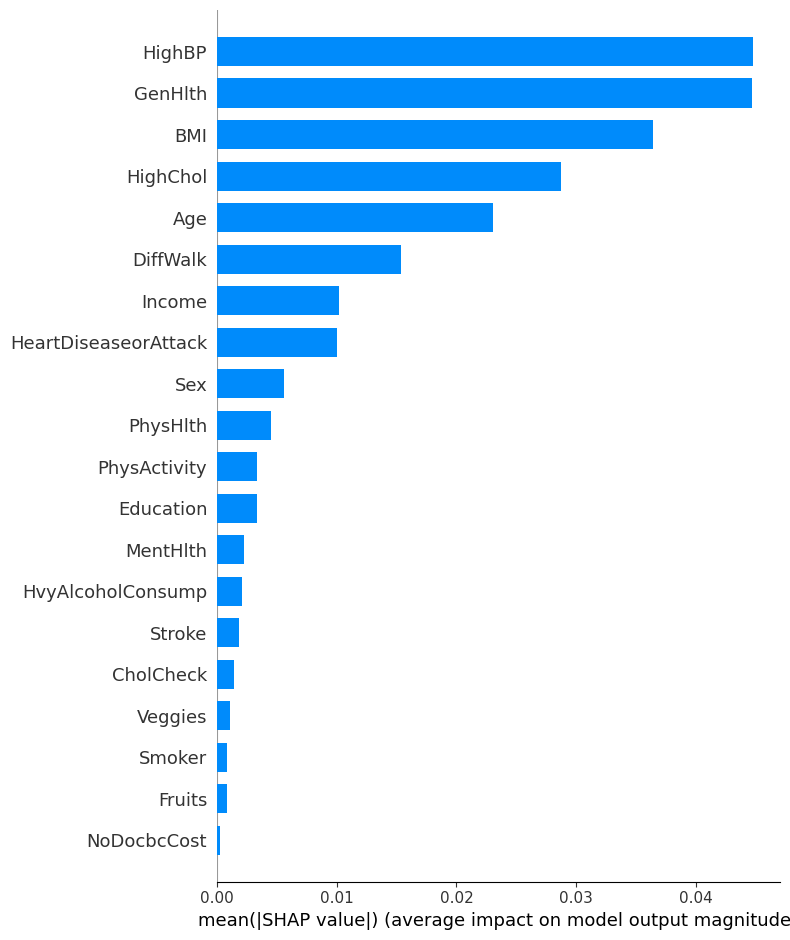

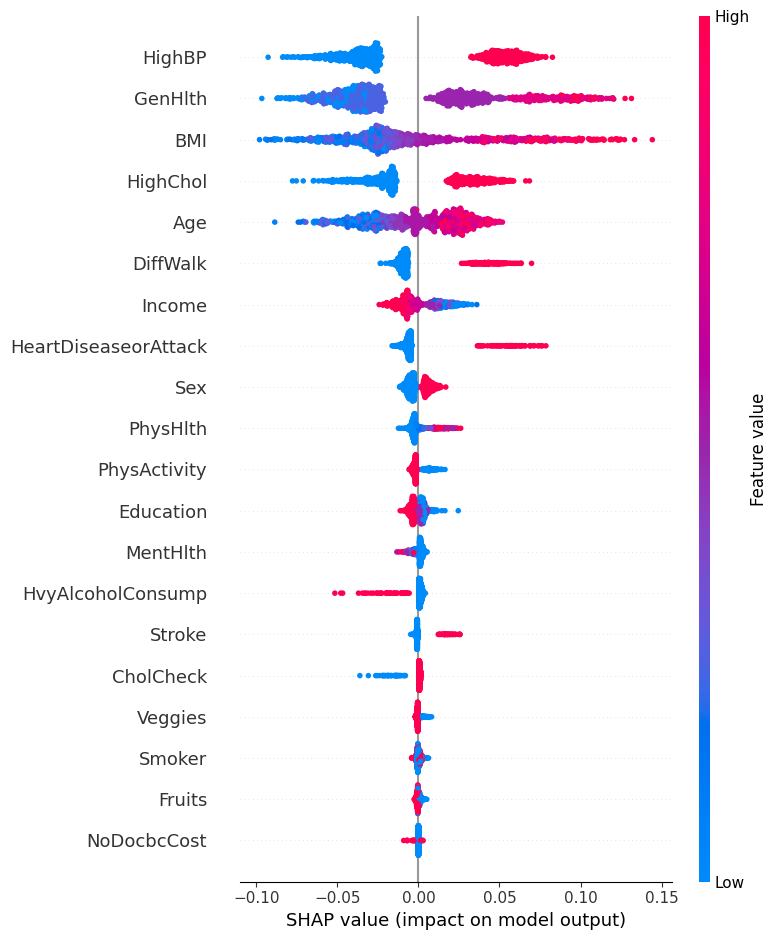

In [22]:
#Subsample - to speed up SHAP computation
rf_sample_size = 1000
X_train_rf_sample = X_train.sample(rf_sample_size, random_state=RANDOM_STATE)

X_rf = X_train_rf_sample[X_train.columns].values  # <-- critical fix

rf_model = best_rf.named_steps["rf"]

explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_rf)  # returns (1000, 21, 2)

shap_values_class1 = shap_values_rf[..., 2]  # shape becomes (1000, 21)

shap.initjs()

# SHAP bar plot
shap.summary_plot(
    shap_values_class1,
    X_rf,
    feature_names=X_train.columns,
    plot_type="bar",
    max_display=20
)

#  SHAP beeswarm plot
shap.summary_plot(
    shap_values_class1,
    X_rf,
    feature_names=X_train.columns,
    max_display=20
)


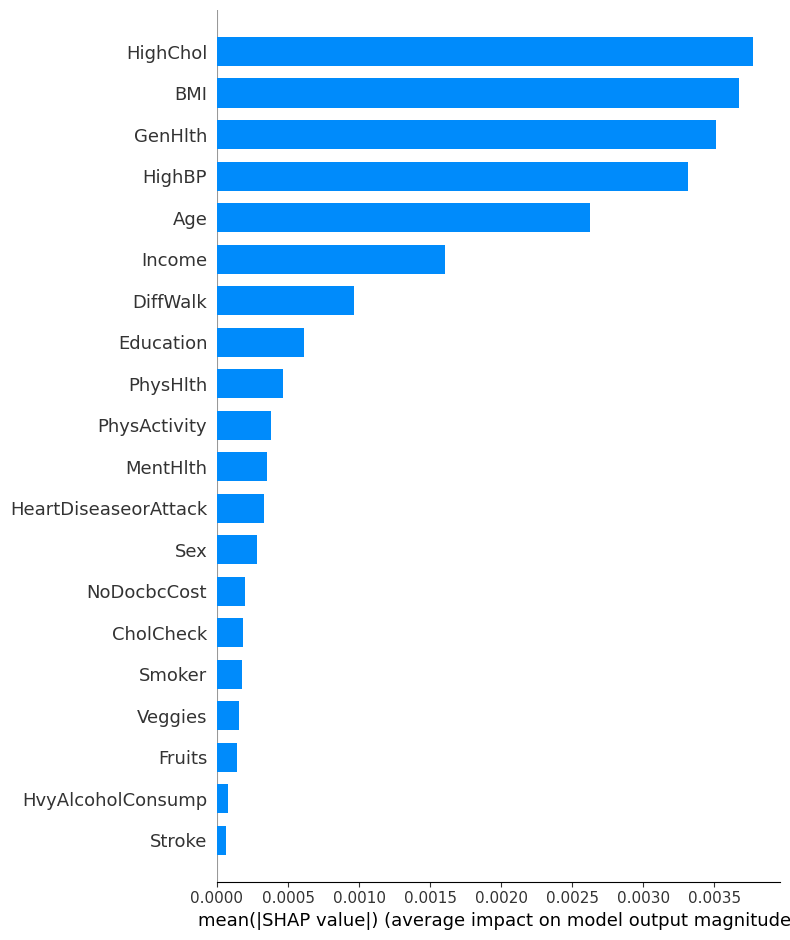

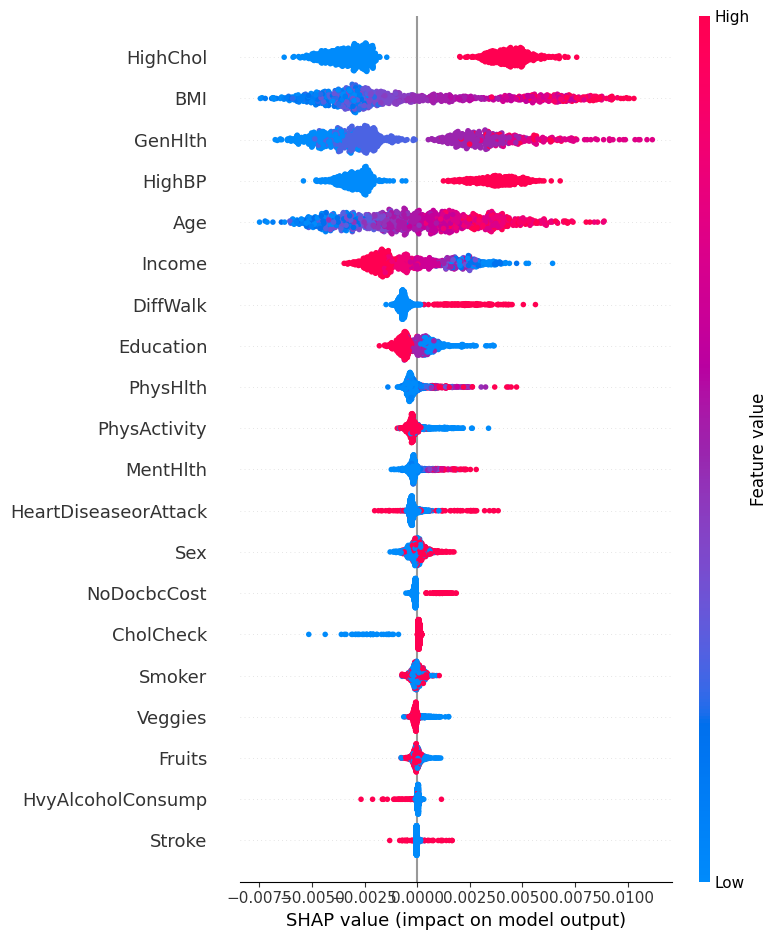

In [23]:
#shap for prediabetes
rf_sample_size = 1000
X_train_rf_sample = X_train.sample(rf_sample_size, random_state=RANDOM_STATE)

X_rf = X_train_rf_sample[X_train.columns].values  #

rf_model = best_rf.named_steps["rf"]

explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_rf)  # returns (1000, 21, 2)

shap_values_class2 = shap_values_rf[..., 1]  

shap.initjs()

# SHAP bar plot
shap.summary_plot(
    shap_values_class2,
    X_rf,
    feature_names=X_train.columns,
    plot_type="bar",
    max_display=20
)

#  SHAP beeswarm plot
shap.summary_plot(
    shap_values_class2,
    X_rf,
    feature_names=X_train.columns,
    max_display=20
)


# Gradient Boost

In [26]:
gb_pipeline = Pipeline(steps=[
    ("gb", GradientBoostingClassifier(random_state=RANDOM_STATE))
])

gb_param_grid = {
    "gb__n_estimators": [100, 200],
    "gb__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "gb__max_depth": [3, 5]
}

gb_scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, average="macro"),
    "recall": make_scorer(recall_score, average="macro"),
    "f1": make_scorer(f1_score, average="macro"),
    "roc_auc": "roc_auc_ovr"
}

gb_grid = GridSearchCV(
    estimator=gb_pipeline,
    param_grid=gb_param_grid,
    scoring=gb_scoring,
    refit="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=2
)

gb_grid.fit(X_train, y_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.01, gb__max_depth=3, gb__n_estimators=100; total time= 1.1min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

[CV] END gb__learning_rate=0.01, gb__max_depth=3, gb__n_estimators=100; total time= 1.1min
[CV] END gb__learning_rate=0.01, gb__max_depth=3, gb__n_estimators=100; total time= 1.1min
[CV] END gb__learning_rate=0.01, gb__max_depth=3, gb__n_estimators=100; total time= 1.2min
[CV] END gb__learning_rate=0.01, gb__max_depth=3, gb__n_estimators=100; total time= 1.2min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.01, gb__max_depth=3, gb__n_estimators=200; total time= 2.5min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.01, gb__max_depth=3, gb__n_estimators=200; total time= 2.5min
[CV] END gb__learning_rate=0.01, gb__max_depth=3, gb__n_estimators=200; total time= 2.5min
[CV] END gb__learning_rate=0.01, gb__max_depth=3, gb__n_estimators=200; total time= 2.5min
[CV] END gb__learning_rate=0.01, gb__max_depth=3, gb__n_estimators=200; total time= 2.5min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.01, gb__max_depth=5, gb__n_estimators=100; total time= 2.3min
[CV] END gb__learning_rate=0.01, gb__max_depth=5, gb__n_estimators=100; total time= 2.3min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.01, gb__max_depth=5, gb__n_estimators=100; total time= 2.3min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.01, gb__max_depth=5, gb__n_estimators=100; total time= 2.3min
[CV] END gb__learning_rate=0.01, gb__max_depth=5, gb__n_estimators=100; total time= 2.3min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.05, gb__max_depth=3, gb__n_estimators=100; total time= 1.2min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.05, gb__max_depth=3, gb__n_estimators=100; total time= 1.2min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.05, gb__max_depth=3, gb__n_estimators=100; total time= 1.2min
[CV] END gb__learning_rate=0.05, gb__max_depth=3, gb__n_estimators=100; total time= 1.2min
[CV] END gb__learning_rate=0.05, gb__max_depth=3, gb__n_estimators=100; total time= 1.2min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.01, gb__max_depth=5, gb__n_estimators=200; total time= 4.1min
[CV] END gb__learning_rate=0.01, gb__max_depth=5, gb__n_estimators=200; total time= 4.1min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.01, gb__max_depth=5, gb__n_estimators=200; total time= 4.1min
[CV] END gb__learning_rate=0.01, gb__max_depth=5, gb__n_estimators=200; total time= 4.2min
[CV] END gb__learning_rate=0.01, gb__max_depth=5, gb__n_estimators=200; total time= 4.2min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.05, gb__max_depth=3, gb__n_estimators=200; total time= 2.4min
[CV] END gb__learning_rate=0.05, gb__max_depth=3, gb__n_estimators=200; total time= 2.4min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.05, gb__max_depth=3, gb__n_estimators=200; total time= 2.4min
[CV] END gb__learning_rate=0.05, gb__max_depth=3, gb__n_estimators=200; total time= 2.4min
[CV] END gb__learning_rate=0.05, gb__max_depth=3, gb__n_estimators=200; total time= 2.4min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.05, gb__max_depth=5, gb__n_estimators=100; total time= 2.1min
[CV] END gb__learning_rate=0.05, gb__max_depth=5, gb__n_estimators=100; total time= 2.1min
[CV] END gb__learning_rate=0.05, gb__max_depth=5, gb__n_estimators=100; total time= 2.1min
[CV] END gb__learning_rate=0.05, gb__max_depth=5, gb__n_estimators=100; total time= 2.1min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.05, gb__max_depth=5, gb__n_estimators=100; total time= 2.1min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.1, gb__max_depth=3, gb__n_estimators=100; total time= 1.2min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.1, gb__max_depth=3, gb__n_estimators=100; total time= 1.2min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.1, gb__max_depth=3, gb__n_estimators=100; total time= 1.2min
[CV] END gb__learning_rate=0.1, gb__max_depth=3, gb__n_estimators=100; total time= 1.2min
[CV] END gb__learning_rate=0.1, gb__max_depth=3, gb__n_estimators=100; total time= 1.2min
[CV] END gb__learning_rate=0.05, gb__max_depth=5, gb__n_estimators=200; total time= 4.1min
[CV] END gb__learning_rate=0.05, gb__max_depth=5, gb__n_estimators=200; total time= 4.1min
[CV] END gb__learning_rate=0.05, gb__max_depth=5, gb__n_estimators=200; total time= 4.1min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.05, gb__max_depth=5, gb__n_estimators=200; total time= 4.1min
[CV] END gb__learning_rate=0.05, gb__max_depth=5, gb__n_estimators=200; total time= 4.1min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.1, gb__max_depth=3, gb__n_estimators=200; total time= 2.5min
[CV] END gb__learning_rate=0.1, gb__max_depth=3, gb__n_estimators=200; total time= 2.5min
[CV] END gb__learning_rate=0.1, gb__max_depth=3, gb__n_estimators=200; total time= 2.5min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.1, gb__max_depth=3, gb__n_estimators=200; total time= 2.5min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.1, gb__max_depth=3, gb__n_estimators=200; total time= 2.5min
[CV] END gb__learning_rate=0.1, gb__max_depth=5, gb__n_estimators=100; total time= 2.2min
[CV] END gb__learning_rate=0.1, gb__max_depth=5, gb__n_estimators=100; total time= 2.2min
[CV] END gb__learning_rate=0.1, gb__max_depth=5, gb__n_estimators=100; total time= 2.2min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.1, gb__max_depth=5, gb__n_estimators=100; total time= 2.2min
[CV] END gb__learning_rate=0.1, gb__max_depth=5, gb__n_estimators=100; total time= 2.2min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.2, gb__max_depth=3, gb__n_estimators=100; total time= 1.3min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.2, gb__max_depth=3, gb__n_estimators=100; total time= 1.3min


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END gb__learning_rate=0.2, gb__max_depth=3, gb__n_estimators=100; total time= 1.3min
[CV] END gb__learning_rate=0.2, gb__max_depth=3, gb__n_estimators=100; total time= 1.3min
[CV] END gb__learning_rate=0.2, gb__max_depth=3, gb__n_estimators=100; total time= 1.3min
[CV] END gb__learning_rate=0.1, gb__max_depth=5, gb__n_estimators=200; total time= 4.5min
[CV] END gb__learning_rate=0.1, gb__max_depth=5, gb__n_estimators=200; total time= 4.5min
[CV] END gb__learning_rate=0.1, gb__max_depth=5, gb__n_estimators=200; total time= 4.5min
[CV] END gb__learning_rate=0.1, gb__max_depth=5, gb__n_estimators=200; total time= 4.5min
[CV] END gb__learning_rate=0.1, gb__max_depth=5, gb__n_estimators=200; total time= 4.5min
[CV] END gb__learning_rate=0.2, gb__max_depth=3, gb__n_estimators=200; total time= 2.8min
[CV] END gb__learning_rate=0.2, gb__max_depth=3, gb__n_estimators=200; total time= 2.8min
[CV] END gb__learning_rate=0.2, gb__max_depth=3, gb__n_estimators=200; total time= 2.8min
[CV] END g

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('gb',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'gb__learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'gb__max_depth': [3, 5],
                         'gb__n_estimators': [100, 200]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy',
                      'f1': make_scorer(f1_score, response_method='predict', average=macro),
                      'precision': make_scorer(precision_score, response_method='predict', average=macro),
                      'recall': make_scorer(recall_score, response_method='predict', average=macro),
                      'roc_auc': 'roc_auc_ovr'},
             verbose=2)

In [27]:
print("Best GB params:", gb_grid.best_params_)
print("Best CV AUC-ROC:", gb_grid.best_score_)

gb_cv_results = pd.DataFrame(gb_grid.cv_results_)
gb_cv_results[[
    "mean_test_accuracy",
    "mean_test_precision",
    "mean_test_recall",
    "mean_test_f1",
    "mean_test_roc_auc",
    "param_gb__n_estimators",
    "param_gb__learning_rate",
    "param_gb__max_depth"
]].sort_values("mean_test_roc_auc", ascending=False).head(10)


Best GB params: {'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__n_estimators': 100}
Best CV AUC-ROC: 0.7891047079027791


,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc,param_gb__n_estimators,param_gb__learning_rate,param_gb__max_depth
8,0.849649,0.474102,0.390535,0.402097,0.789105,100,0.10,3
5,0.849535,0.473809,0.390028,0.401441,0.788940,200,0.05,3
9,0.849933,0.474964,0.391198,0.402973,0.788891,200,0.10,3
12,0.849714,0.473704,0.392526,0.404552,0.788340,100,0.20,3
6,0.849925,0.477313,0.386375,0.396900,0.787977,100,0.05,5
4,0.849351,0.476102,0.383144,0.392525,0.787562,100,0.05,3
7,0.849986,0.476408,0.389097,0.400405,0.787256,200,0.05,5
10,0.849859,0.475643,0.389265,0.400583,0.787017,100,0.10,5
13,0.849960,0.542176,0.391313,0.403235,0.786985,200,0.20,3
3,0.848707,0.486584,0.367504,0.369536,0.784678,200,0.01,5


In [28]:
best_gb = gb_grid.best_estimator_
gb_test_metrics = evaluate_on_test_set(best_gb, X_test, y_test)


=== Test set performance ===
Accuracy : 0.8500
Precision (macro): 0.4700
Recall (macro)   : 0.3917
F1-score (macro) : 0.4034
AUC-ROC (OvR)    : 0.7838

Classification report:
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92     21401
         1.0       0.00      0.00      0.00       473
         2.0       0.54      0.20      0.29      3494

    accuracy                           0.85     25368
   macro avg       0.47      0.39      0.40     25368
weighted avg       0.81      0.85      0.81     25368

Confusion matrix:
[[20863     2   536]
 [  421     0    52]
 [ 2794     0   700]]


In [29]:
comparison = pd.DataFrame({
    "model": ["KNN", "RandomForest", "GradientBoosting"],
    "accuracy": [
        knn_test_metrics["accuracy"], 
        rf_test_metrics["accuracy"], 
        gb_test_metrics["accuracy"]
    ],
    "precision_macro": [
        knn_test_metrics["precision_macro"],
        rf_test_metrics["precision_macro"],
        gb_test_metrics["precision_macro"]
    ],
    "recall_macro": [
        knn_test_metrics["recall_macro"],
        rf_test_metrics["recall_macro"],
        gb_test_metrics["recall_macro"]
    ],
    "f1_macro": [
        knn_test_metrics["f1_macro"],
        rf_test_metrics["f1_macro"],
        gb_test_metrics["f1_macro"]
    ],
    "auc_roc_ovr": [
        knn_test_metrics["auc_roc_ovr"],
        rf_test_metrics["auc_roc_ovr"],
        gb_test_metrics["auc_roc_ovr"]
    ]
})

comparison


,model,accuracy,precision_macro,recall_macro,f1_macro,auc_roc_ovr
0,KNN,0.846145,0.477411,0.349816,0.339176,0.772359
1,RandomForest,0.849535,0.477996,0.371112,0.375314,0.779527
2,GradientBoosting,0.850008,0.469985,0.391735,0.403414,0.783850
